In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
img_folder = '../Hierarchical-Localization/datasets/front-door/'
image_paths = ['IMG_1197.JPG', 'IMG_1223.JPG', 'IMG_1224.JPG']

# === Step 1: Load Images ===
images = [cv2.imread(img_folder+p) for p in image_paths]  # OpenCV loads in BGR

# === Step 2: OpenCV Point Picker ===
def get_points_opencv(image, window_name='Image', n_points=4):
    points = []

    def mouse_handler(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN and len(points) < n_points:
            points.append((x, y))
            cv2.circle(image, (x, y), 5, (0, 255, 0), -1)
            cv2.imshow(window_name, image)

    clone = image.copy()
    cv2.imshow(window_name, clone)
    cv2.setMouseCallback(window_name, mouse_handler)

    print(f"Click {n_points} points on {window_name}...")
    while len(points) < n_points:
        cv2.waitKey(1)

    cv2.destroyWindow(window_name)
    return np.array(points, dtype=np.float32)

# Step 3: Select Points
selected_points = []
for i in range(3):
    selected = get_points_opencv(images[i].copy(), f'Select points: Image {i+1}', n_points=4)
    selected_points.append(selected)

# === Step 4: Convert to Homogeneous Coordinates ===
def to_homogeneous(pts):
    return np.hstack([pts, np.ones((pts.shape[0], 1))])

x1 = to_homogeneous(selected_points[0])
x2 = to_homogeneous(selected_points[1])
x3 = to_homogeneous(selected_points[2])

# === Step 5: DLT Homography Estimation ===
def compute_homography(x_src, x_dst):
    n = x_src.shape[0]
    A = []
    for i in range(n):
        X, Y, W = x_src[i]
        x, y, w = x_dst[i]
        A.append([0, 0, 0, -w*X, -w*Y, -w*W, y*X, y*Y, y*W])
        A.append([w*X, w*Y, w*W, 0, 0, 0, -x*X, -x*Y, -x*W])
    A = np.array(A)
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    return H / H[-1, -1]

H12 = compute_homography(x1, x2)
H13 = compute_homography(x1, x3)

# === Step 6: Verify Mapping Consistency ===
def apply_homography(H, pts):
    projected = H @ pts.T
    return (projected[:2] / projected[2]).T

x2_pred = apply_homography(H12, x1)
x3_pred = apply_homography(H13, x1)

# === Step 7: Visualization ===
def draw_matches(image, true_pts, pred_pts, title='Comparison'):
    img = image.copy()
    for i in range(len(true_pts)):
        cv2.circle(img, tuple(true_pts[i].astype(int)), 5, (0, 255, 0), -1)
        cv2.circle(img, tuple(pred_pts[i].astype(int)), 5, (0, 0, 255), 2)
        cv2.line(img, tuple(true_pts[i].astype(int)), tuple(pred_pts[i].astype(int)), (255, 255, 0), 1)
    cv2.imshow(title, img)
    cv2.waitKey(0)
    cv2.destroyWindow(title)

# Convert RGB for OpenCV display
img2_rgb = cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB)
img3_rgb = cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB)

draw_matches(img2_rgb, selected_points[1], x2_pred, "Image 2: Ground Truth vs Predicted")
draw_matches(img3_rgb, selected_points[2], x3_pred, "Image 3: Ground Truth vs Predicted")

: 

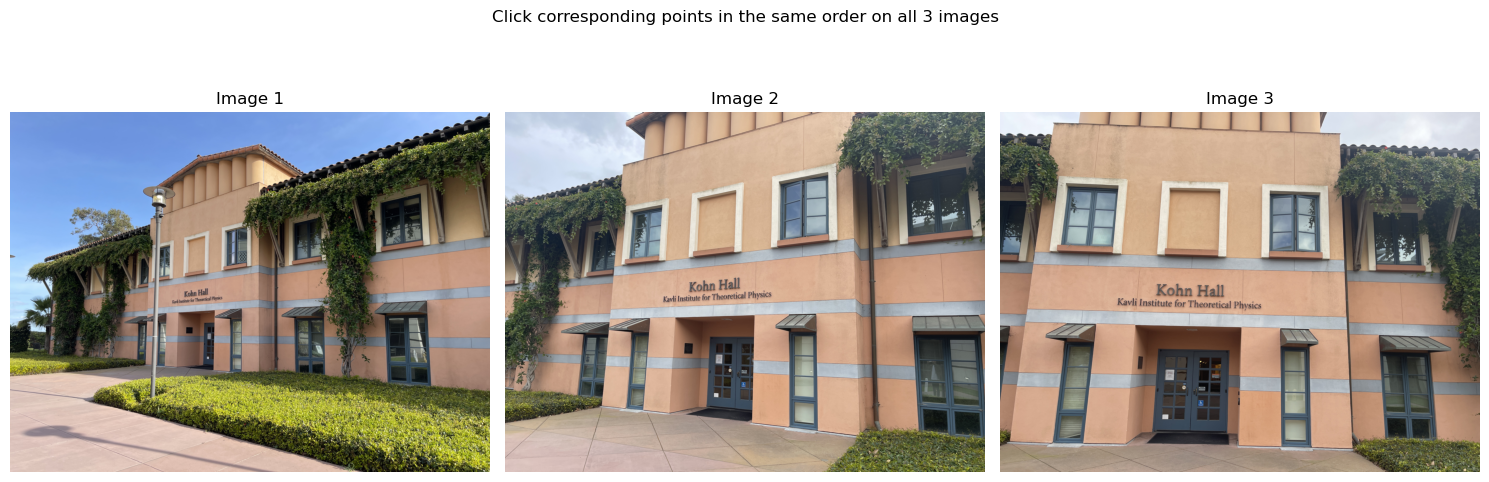

In [5]:

# === Step 2: Manual Point Selection ===
selected_points = [[] for _ in range(3)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle('Click corresponding points in the same order on all 3 images')

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.8)


Select at least 4 points in Image 1


KeyboardInterrupt: 

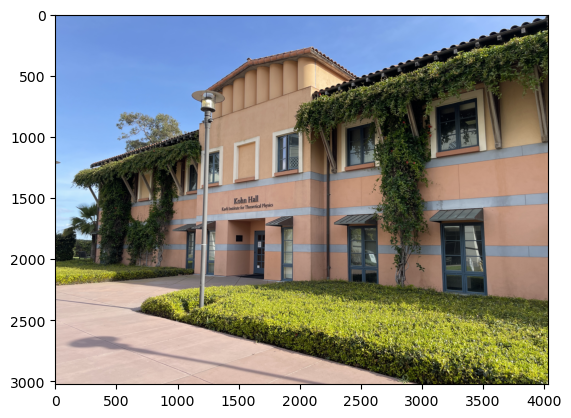

In [6]:

# Collect points manually using ginput
for i in range(3):
    print(f"Select at least 4 points in Image {i+1}")
    plt.figure()
    plt.imshow(images[i])
    pts = plt.ginput(n=4, timeout=0)
    selected_points[i] = np.array(pts)
    plt.close()

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
points_img1 = []

def onclick(event):
    global points_img1
    points_img1.append((event.xdata, event.ydata))
    print(f"Point selected: {event.xdata}, {event.ydata}")

fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()


<IPython.core.display.Javascript object>

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load your image
img = cv2.imread('../Hierarchical-Localization/datasets/front-door/IMG_1197.JPG')

# Create a figure and display the image
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Click to select points; close the window when done.")


# List to store the coordinates
coords = []

# Define the event handler
def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        coords.append((event.xdata, event.ydata))
        ax.plot(event.xdata, event.ydata, 'ro')  # Mark the point
        fig.canvas.draw()

# Connect the event handler to the figure
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()


<IPython.core.display.Javascript object>

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the image
fig, ax = plt.subplots()
ax.imshow(img1)
plt.title("Click to select points; close the window when done.")

# List to store selected points
selected_points = []

# Event handler for mouse clicks
def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        x, y = event.xdata, event.ydata
        selected_points.append((x, y))
        ax.plot(x, y, 'ro')  # Mark the selected point
        fig.canvas.draw()

# Connect the event handler
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

# After closing the plot window
print("Selected points:")
for point in selected_points:
    print(point)


<IPython.core.display.Javascript object>

Selected points:


In [9]:
fig, ax = plt.subplots()
ax.imshow(img1)
plt.title("Click to select points; middle click to finish.")

# Allow the user to select points
points = plt.ginput(n=-1, timeout=0)

# Close the plot window
plt.close()

# Display the selected points
print("Selected points:")
for point in points:
    print(point)

<IPython.core.display.Javascript object>

KeyboardInterrupt: 